In [1]:
from datasets import load_dataset
from transformers import AutoModelForSequenceClassification,AutoTokenizer,Trainer,AutoModel
import pandas as pd
import numpy as np
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score,classification_report,ConfusionMatrixDisplay
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from tqdm.notebook import tqdm
from IPython.display import clear_output,display

/opt/conda/lib/python3.10/site-packages/transformers/utils/generic.py:311: UserWarning: torch.utils._pytree._register_pytree_node is deprecated. Please use torch.utils._pytree.register_pytree_node instead.
  torch.utils._pytree._register_pytree_node(
/opt/conda/lib/python3.10/site-packages/transformers/utils/generic.py:311: UserWarning: torch.utils._pytree._register_pytree_node is deprecated. Please use torch.utils._pytree.register_pytree_node instead.
  torch.utils._pytree._register_pytree_node(


In [2]:
ds = load_dataset("papluca/language-identification")

In [3]:
ds

DatasetDict({
    train: Dataset({
        features: ['labels', 'text'],
        num_rows: 70000
    })
    validation: Dataset({
        features: ['labels', 'text'],
        num_rows: 10000
    })
    test: Dataset({
        features: ['labels', 'text'],
        num_rows: 10000
    })
})

In [4]:
ds['validation'] = ds['validation'].train_test_split(test_size = 0.24) 

In [5]:
ds

DatasetDict({
    train: Dataset({
        features: ['labels', 'text'],
        num_rows: 70000
    })
    validation: DatasetDict({
        train: Dataset({
            features: ['labels', 'text'],
            num_rows: 7600
        })
        test: Dataset({
            features: ['labels', 'text'],
            num_rows: 2400
        })
    })
    test: Dataset({
        features: ['labels', 'text'],
        num_rows: 10000
    })
})

In [6]:
label2id = dict.fromkeys(pd.Series(ds['train']['labels']).unique())

In [7]:
c = 0
for key,val in label2id.items():
    label2id[key] = c
    c = c + 1

In [8]:
label2id

{'pt': 0,
 'bg': 1,
 'zh': 2,
 'th': 3,
 'ru': 4,
 'pl': 5,
 'ur': 6,
 'sw': 7,
 'tr': 8,
 'es': 9,
 'ar': 10,
 'it': 11,
 'hi': 12,
 'de': 13,
 'el': 14,
 'nl': 15,
 'fr': 16,
 'vi': 17,
 'en': 18,
 'ja': 19}

In [9]:
id2label = dict.fromkeys(list(label2id.values()))

In [10]:
for key,val in label2id.items():
    id2label[val] = key 

In [11]:
id2label

{0: 'pt',
 1: 'bg',
 2: 'zh',
 3: 'th',
 4: 'ru',
 5: 'pl',
 6: 'ur',
 7: 'sw',
 8: 'tr',
 9: 'es',
 10: 'ar',
 11: 'it',
 12: 'hi',
 13: 'de',
 14: 'el',
 15: 'nl',
 16: 'fr',
 17: 'vi',
 18: 'en',
 19: 'ja'}

In [12]:
model = AutoModelForSequenceClassification.from_pretrained("microsoft/mdeberta-v3-base",device_map = "cuda:0",num_labels = 20,label2id = label2id,id2label=id2label)
tokenizer = AutoTokenizer.from_pretrained("microsoft/mdeberta-v3-base")


Some weights of DebertaV2ForSequenceClassification were not initialized from the model checkpoint at microsoft/mdeberta-v3-base and are newly initialized: ['pooler.dense.bias', 'classifier.weight', 'pooler.dense.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/opt/conda/lib/python3.10/site-packages/transformers/convert_slow_tokenizer.py:473: UserWarning: The sentencepiece tokenizer that you are converting to a fast tokenizer uses the byte fallback option which is not implemented in the fast tokenizers. In practice this means that the fast version of the tokenizer can produce unknown tokens whereas the sentencepiece version would have converted these unknown tokens into a sequence of byte tokens matching the original piece of text.
  warnings.warn(


In [13]:
def computeMetrics(evalPreds):
    logits,labels = evalPreds
    preds = np.argmax(logits,axis = 1)
    accuracy = accuracy_score(labels,preds)
    precision = precision_score(labels,preds, average='weighted')
    recall = recall_score(labels,preds, average='weighted')
    f1 = f1_score(labels,preds, average='weighted')
    return {"accuracy": accuracy,"precision": precision,"recall": recall,"f1": f1}

In [14]:
def preProcessLabels(ex):
    ex['labels'] = label2id[ex['labels']]
    return ex
ds['train'] = ds['train'].map(preProcessLabels)
ds['validation'] = ds['validation']['test'].map(preProcessLabels)
ds['test'] = ds['test'].map(preProcessLabels)

Map:   0%|          | 0/2400 [00:00<?, ? examples/s]

In [15]:
def tokenizeDS(batch):
    return tokenizer(batch["text"], padding="max_length", truncation=True,return_tensors = "pt",max_length = 512)
ds['train'] = ds['train'].map(tokenizeDS,batched = True,batch_size = 10000)
ds['validation'] = ds['validation'].map(tokenizeDS,batched = True,batch_size = 10000)
ds['test'] = ds['test'].map(tokenizeDS,batched = True,batch_size = 10000)
ds['train'].set_format("torch")
ds['validation'].set_format("torch")
ds['test'].set_format("torch")

Map:   0%|          | 0/2400 [00:00<?, ? examples/s]

### Trained model for 1000 Steps With Default pooling

In [ ]:
training_args = TrainingArguments(
    output_dir="mdebertaV1",
    do_train=True,
    do_eval=True,
    per_device_train_batch_size=10, 
    per_device_eval_batch_size=10,
    warmup_steps=10,
    num_train_epochs=3, 
    learning_rate=3e-5,
    weight_decay=0.03,
    evaluation_strategy="steps",
    save_strategy="steps",
    load_best_model_at_end=True,
    logging_steps=100,
    eval_steps = 100,
    overwrite_output_dir = True,
    metric_for_best_model = "eval_loss",
    remove_unused_columns=False,
)
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=ds['train'],
    eval_dataset=ds['validation'],
    compute_metrics=computeMetrics
)
trainer.can_return_loss = True
trainer.train()

### Load Model

In [17]:
model = AutoModelForSequenceClassification.from_pretrained("mdebertaV1/checkpoint-1000",local_files_only = True,device_map = "cuda:0")

In [18]:
model

DebertaV2ForSequenceClassification(
  (deberta): DebertaV2Model(
    (embeddings): DebertaV2Embeddings(
      (word_embeddings): Embedding(251000, 768, padding_idx=0)
      (LayerNorm): LayerNorm((768,), eps=1e-07, elementwise_affine=True)
      (dropout): StableDropout()
    )
    (encoder): DebertaV2Encoder(
      (layer): ModuleList(
        (0-11): 12 x DebertaV2Layer(
          (attention): DebertaV2Attention(
            (self): DisentangledSelfAttention(
              (query_proj): Linear(in_features=768, out_features=768, bias=True)
              (key_proj): Linear(in_features=768, out_features=768, bias=True)
              (value_proj): Linear(in_features=768, out_features=768, bias=True)
              (pos_dropout): StableDropout()
              (dropout): StableDropout()
            )
            (output): DebertaV2SelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-07, elementwise_affine

In [34]:
def evaluateTest():
    evalds = ds['test'].set_format("torch", columns=["input_ids", "attention_mask",'token_type_ids'])
    dl = DataLoader(ds['test'], batch_size=10)
    predictions = []
    with torch.no_grad():
        for batch in tqdm(dl):
            batch = {k: v.cuda() for k, v in batch.items()}
            model.eval()
            preds = model(**batch)
            predictions.extend(preds.logits.argmax(1).detach().cpu().numpy())
    return predictions

In [35]:
preds = evaluateTest()

100% 1000/1000 [07:15<00:00,  2.30it/s]


### Metrics

In [40]:
print("Accuracy:",accuracy_score(ds['test']['labels'],preds))
print("Precision:",precision_score(ds['test']['labels'],preds, average='weighted'))
print("Recall:",recall_score(ds['test']['labels'],preds, average='weighted'))
print("F1:",f1_score(ds['test']['labels'],preds, average='weighted'))

Accuracy: 0.9956
Precision: 0.9956583586115858
Recall: 0.9956
F1: 0.9956008000847106


In [46]:
print(classification_report(ds['test']['labels'],preds,target_names = list(label2id.keys())))

              precision    recall  f1-score   support

          pt       0.99      0.99      0.99       500
          bg       0.99      1.00      1.00       500
          zh       1.00      1.00      1.00       500
          th       1.00      1.00      1.00       500
          ru       1.00      1.00      1.00       500
          pl       1.00      0.99      1.00       500
          ur       0.97      0.99      0.98       500
          sw       0.97      1.00      0.99       500
          tr       0.99      1.00      1.00       500
          es       0.99      1.00      1.00       500
          ar       1.00      1.00      1.00       500
          it       1.00      0.98      0.99       500
          hi       1.00      0.97      0.98       500
          de       1.00      1.00      1.00       500
          el       1.00      1.00      1.00       500
          nl       1.00      1.00      1.00       500
          fr       1.00      1.00      1.00       500
          vi       1.00    

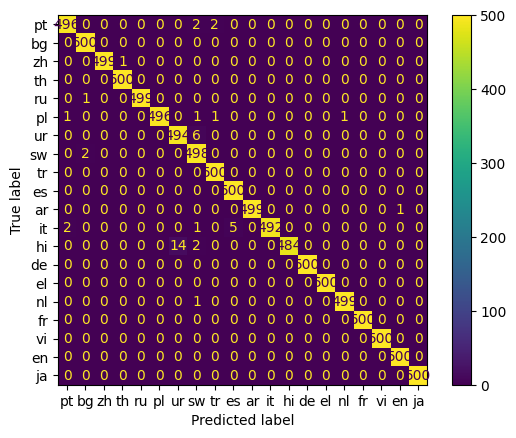

In [47]:
ConfusionMatrixDisplay.from_predictions(ds['test']['labels'],preds,display_labels = list(label2id.keys()))

In [2]:
model = AutoModel.from_pretrained("microsoft/mdeberta-v3-base",device_map = "cuda:0")
tokenizer = AutoTokenizer.from_pretrained("microsoft/mdeberta-v3-base")

/opt/conda/lib/python3.10/site-packages/transformers/convert_slow_tokenizer.py:473: UserWarning: The sentencepiece tokenizer that you are converting to a fast tokenizer uses the byte fallback option which is not implemented in the fast tokenizers. In practice this means that the fast version of the tokenizer can produce unknown tokens whereas the sentencepiece version would have converted these unknown tokens into a sequence of byte tokens matching the original piece of text.
  warnings.warn(


In [3]:
ds = load_dataset("papluca/language-identification")

In [4]:
ds['validation'] = ds['validation'].train_test_split(test_size = 0.2)

In [5]:
ds['validation'] = ds['validation']['test']

In [6]:
ds

DatasetDict({
    train: Dataset({
        features: ['labels', 'text'],
        num_rows: 70000
    })
    validation: Dataset({
        features: ['labels', 'text'],
        num_rows: 2000
    })
    test: Dataset({
        features: ['labels', 'text'],
        num_rows: 10000
    })
})

In [7]:
label2id = dict.fromkeys(pd.Series(ds['train']['labels']).unique())
c = 0
for key,val in label2id.items():
    label2id[key] = c
    c = c + 1

In [8]:
def preProcessLabels(ex):
    ex['labels'] = label2id[ex['labels']]
    return ex
ds['train'] = ds['train'].map(preProcessLabels)
ds['validation'] = ds['validation'].map(preProcessLabels)
ds['test'] = ds['test'].map(preProcessLabels)

Map:   0%|          | 0/2000 [00:00<?, ? examples/s]

In [9]:
def tokenizeDS(batch):
    return tokenizer(batch["text"], padding="max_length", truncation=True,return_tensors = "pt",max_length = 512)
ds['train'] = ds['train'].map(tokenizeDS,batched = True,batch_size = 10000)
ds['validation'] = ds['validation'].map(tokenizeDS,batched = True,batch_size = 10000)
ds['test'] = ds['test'].map(tokenizeDS,batched = True,batch_size = 10000)
ds['train'].set_format("torch")
ds['validation'].set_format("torch")
ds['test'].set_format("torch")

Map:   0%|          | 0/2000 [00:00<?, ? examples/s]

### Custom pooling, Averaging Embeddings of All Tokens

In [10]:
class langClassifier(nn.Module):
    def __init__(self):
        super().__init__()
        self.model = model
        self.model.train()
        self.dense = nn.Linear(768,20)
    def forward(self,x):
        hs = self.model(**x).last_hidden_state
        pool = hs.mean(dim = 1)
        logits = self.dense(pool)
        return logits
lc = langClassifier().cuda()

In [11]:
lossFN= nn.CrossEntropyLoss()
optimizer = optim.AdamW(lc.parameters(),lr = 0.00003)

In [12]:
train = DataLoader(ds['train'],batch_size = 10)
val = DataLoader(ds['validation'],batch_size = 10)
test = DataLoader(ds['test'],batch_size = 10)

### Trained Model for 7000 Steps to acheive similar performance

In [13]:
step = 0
total_loss = 0.0
for batch in tqdm(train):
    lc.train()
    labels = batch['labels'].type(torch.LongTensor).cuda()
    inputs = {key: batch[key] for key in ["input_ids","attention_mask","token_type_ids"]}
    inputs = {k:v.cuda() for k,v in inputs.items()}
    logits = lc(inputs)
    loss = lossFN(logits,labels)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    total_loss += loss.item()*10
    step = step+1
    if step%100 == 0:
        preds = []
        labs = []
        val_loss = 0.0
        for valBatch in tqdm(val,leave=False):
            with torch.no_grad():
                lc.eval()
                valLabels = valBatch['labels'].type(torch.LongTensor).cuda()
                labs.extend(list(valBatch['labels'].detach().cpu().numpy()))
                inputs = {key: valBatch[key] for key in ["input_ids","attention_mask","token_type_ids"]}
                inputs = {k:v.cuda() for k,v in inputs.items()}
                logits = lc(inputs)
                loss = lossFN(logits,valLabels)
                val_loss += loss.item()*10
                preds.extend(list(logits.argmax(1).detach().cpu().numpy()))
        accuracy = accuracy_score(labs,preds)
        precision = precision_score(labs,preds, average='weighted')
        recall = recall_score(labs,preds, average='weighted')
        f1 = f1_score(labs,preds, average='weighted')
        metrics = {"Training Loss":round(total_loss/(1000),4),"Validation Loss":round(val_loss/2000,4),"Accuracy": accuracy,"Precision": round(precision,4),"Recall": round(recall,4),"F1": round(f1,4)}
        total_loss = 0.0
        print(metrics)
        

  0%|          | 0/7000 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


{'Training Loss': 2.9423, 'Validation Loss': 2.8289, 'Accuracy': 0.249, 'Precision': 0.4737, 'Recall': 0.249, 'F1': 0.2172}


  0%|          | 0/200 [00:00<?, ?it/s]

/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


{'Training Loss': 2.6535, 'Validation Loss': 2.5307, 'Accuracy': 0.562, 'Precision': 0.7509, 'Recall': 0.562, 'F1': 0.539}


  0%|          | 0/200 [00:00<?, ?it/s]

{'Training Loss': 2.5021, 'Validation Loss': 2.3934, 'Accuracy': 0.5675, 'Precision': 0.9398, 'Recall': 0.5675, 'F1': 0.6234}


  0%|          | 0/200 [00:00<?, ?it/s]

{'Training Loss': 2.3809, 'Validation Loss': 2.3208, 'Accuracy': 0.8245, 'Precision': 0.9357, 'Recall': 0.8245, 'F1': 0.8461}


  0%|          | 0/200 [00:00<?, ?it/s]

{'Training Loss': 2.3409, 'Validation Loss': 2.288, 'Accuracy': 0.7095, 'Precision': 0.9425, 'Recall': 0.7095, 'F1': 0.7481}


  0%|          | 0/200 [00:00<?, ?it/s]

{'Training Loss': 2.2933, 'Validation Loss': 2.2265, 'Accuracy': 0.881, 'Precision': 0.9601, 'Recall': 0.881, 'F1': 0.902}


  0%|          | 0/200 [00:00<?, ?it/s]

{'Training Loss': 2.2567, 'Validation Loss': 2.2081, 'Accuracy': 0.781, 'Precision': 0.9232, 'Recall': 0.781, 'F1': 0.7951}


  0%|          | 0/200 [00:00<?, ?it/s]

{'Training Loss': 2.243, 'Validation Loss': 2.1865, 'Accuracy': 0.8255, 'Precision': 0.9211, 'Recall': 0.8255, 'F1': 0.8366}


  0%|          | 0/200 [00:00<?, ?it/s]

{'Training Loss': 2.1741, 'Validation Loss': 2.1693, 'Accuracy': 0.8735, 'Precision': 0.9423, 'Recall': 0.8735, 'F1': 0.8827}


  0%|          | 0/200 [00:00<?, ?it/s]

{'Training Loss': 2.18, 'Validation Loss': 2.1338, 'Accuracy': 0.8255, 'Precision': 0.9597, 'Recall': 0.8255, 'F1': 0.853}


  0%|          | 0/200 [00:00<?, ?it/s]

{'Training Loss': 2.132, 'Validation Loss': 2.0991, 'Accuracy': 0.9255, 'Precision': 0.9545, 'Recall': 0.9255, 'F1': 0.9311}


  0%|          | 0/200 [00:00<?, ?it/s]

{'Training Loss': 2.1439, 'Validation Loss': 2.0793, 'Accuracy': 0.953, 'Precision': 0.975, 'Recall': 0.953, 'F1': 0.9581}


  0%|          | 0/200 [00:00<?, ?it/s]

{'Training Loss': 2.131, 'Validation Loss': 2.068, 'Accuracy': 0.8785, 'Precision': 0.9627, 'Recall': 0.8785, 'F1': 0.9043}


  0%|          | 0/200 [00:00<?, ?it/s]

{'Training Loss': 2.0973, 'Validation Loss': 2.0397, 'Accuracy': 0.885, 'Precision': 0.9633, 'Recall': 0.885, 'F1': 0.9088}


  0%|          | 0/200 [00:00<?, ?it/s]

{'Training Loss': 2.0604, 'Validation Loss': 2.016, 'Accuracy': 0.9115, 'Precision': 0.9593, 'Recall': 0.9115, 'F1': 0.9241}


  0%|          | 0/200 [00:00<?, ?it/s]

{'Training Loss': 2.0513, 'Validation Loss': 2.0396, 'Accuracy': 0.8345, 'Precision': 0.9221, 'Recall': 0.8345, 'F1': 0.8451}


  0%|          | 0/200 [00:00<?, ?it/s]

{'Training Loss': 2.021, 'Validation Loss': 1.9878, 'Accuracy': 0.934, 'Precision': 0.9595, 'Recall': 0.934, 'F1': 0.9373}


  0%|          | 0/200 [00:00<?, ?it/s]

{'Training Loss': 1.9902, 'Validation Loss': 1.9646, 'Accuracy': 0.9065, 'Precision': 0.9672, 'Recall': 0.9065, 'F1': 0.9247}


  0%|          | 0/200 [00:00<?, ?it/s]

{'Training Loss': 1.9802, 'Validation Loss': 1.9442, 'Accuracy': 0.951, 'Precision': 0.9745, 'Recall': 0.951, 'F1': 0.9567}


  0%|          | 0/200 [00:00<?, ?it/s]

{'Training Loss': 1.9968, 'Validation Loss': 1.9299, 'Accuracy': 0.9515, 'Precision': 0.9692, 'Recall': 0.9515, 'F1': 0.9559}


  0%|          | 0/200 [00:00<?, ?it/s]

{'Training Loss': 1.9316, 'Validation Loss': 1.9061, 'Accuracy': 0.916, 'Precision': 0.9643, 'Recall': 0.916, 'F1': 0.9289}


  0%|          | 0/200 [00:00<?, ?it/s]

{'Training Loss': 1.9235, 'Validation Loss': 1.8873, 'Accuracy': 0.961, 'Precision': 0.9744, 'Recall': 0.961, 'F1': 0.9635}


  0%|          | 0/200 [00:00<?, ?it/s]

{'Training Loss': 1.8952, 'Validation Loss': 1.86, 'Accuracy': 0.9845, 'Precision': 0.9856, 'Recall': 0.9845, 'F1': 0.9845}


  0%|          | 0/200 [00:00<?, ?it/s]

{'Training Loss': 1.9207, 'Validation Loss': 1.8494, 'Accuracy': 0.892, 'Precision': 0.9474, 'Recall': 0.892, 'F1': 0.9048}


  0%|          | 0/200 [00:00<?, ?it/s]

{'Training Loss': 1.9171, 'Validation Loss': 1.8291, 'Accuracy': 0.9475, 'Precision': 0.9728, 'Recall': 0.9475, 'F1': 0.9538}


  0%|          | 0/200 [00:00<?, ?it/s]

{'Training Loss': 1.8238, 'Validation Loss': 1.8045, 'Accuracy': 0.988, 'Precision': 0.9899, 'Recall': 0.988, 'F1': 0.9883}


  0%|          | 0/200 [00:00<?, ?it/s]

{'Training Loss': 1.8258, 'Validation Loss': 1.786, 'Accuracy': 0.951, 'Precision': 0.9729, 'Recall': 0.951, 'F1': 0.9566}


  0%|          | 0/200 [00:00<?, ?it/s]

{'Training Loss': 1.8398, 'Validation Loss': 1.7648, 'Accuracy': 0.9335, 'Precision': 0.9718, 'Recall': 0.9335, 'F1': 0.9448}


  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

{'Training Loss': 1.7938, 'Validation Loss': 1.7321, 'Accuracy': 0.9175, 'Precision': 0.9671, 'Recall': 0.9175, 'F1': 0.9315}


  0%|          | 0/200 [00:00<?, ?it/s]

{'Training Loss': 1.7596, 'Validation Loss': 1.7003, 'Accuracy': 0.9865, 'Precision': 0.9883, 'Recall': 0.9865, 'F1': 0.9868}


  0%|          | 0/200 [00:00<?, ?it/s]

{'Training Loss': 1.7547, 'Validation Loss': 1.698, 'Accuracy': 0.971, 'Precision': 0.9768, 'Recall': 0.971, 'F1': 0.9706}


  0%|          | 0/200 [00:00<?, ?it/s]

{'Training Loss': 1.7015, 'Validation Loss': 1.6702, 'Accuracy': 0.969, 'Precision': 0.9763, 'Recall': 0.969, 'F1': 0.97}


  0%|          | 0/200 [00:00<?, ?it/s]

{'Training Loss': 1.6914, 'Validation Loss': 1.6539, 'Accuracy': 0.9825, 'Precision': 0.9839, 'Recall': 0.9825, 'F1': 0.9824}


  0%|          | 0/200 [00:00<?, ?it/s]

{'Training Loss': 1.6365, 'Validation Loss': 1.6226, 'Accuracy': 0.98, 'Precision': 0.9817, 'Recall': 0.98, 'F1': 0.9801}


  0%|          | 0/200 [00:00<?, ?it/s]

{'Training Loss': 1.6463, 'Validation Loss': 1.615, 'Accuracy': 0.9825, 'Precision': 0.9856, 'Recall': 0.9825, 'F1': 0.9832}


  0%|          | 0/200 [00:00<?, ?it/s]

{'Training Loss': 1.6338, 'Validation Loss': 1.5919, 'Accuracy': 0.966, 'Precision': 0.9766, 'Recall': 0.966, 'F1': 0.9685}


  0%|          | 0/200 [00:00<?, ?it/s]

{'Training Loss': 1.6245, 'Validation Loss': 1.5983, 'Accuracy': 0.963, 'Precision': 0.975, 'Recall': 0.963, 'F1': 0.9609}


  0%|          | 0/200 [00:00<?, ?it/s]

{'Training Loss': 1.6188, 'Validation Loss': 1.5488, 'Accuracy': 0.9665, 'Precision': 0.9741, 'Recall': 0.9665, 'F1': 0.9679}


  0%|          | 0/200 [00:00<?, ?it/s]

{'Training Loss': 1.5594, 'Validation Loss': 1.5449, 'Accuracy': 0.918, 'Precision': 0.9643, 'Recall': 0.918, 'F1': 0.9302}


  0%|          | 0/200 [00:00<?, ?it/s]

{'Training Loss': 1.5585, 'Validation Loss': 1.5097, 'Accuracy': 0.9695, 'Precision': 0.9795, 'Recall': 0.9695, 'F1': 0.9716}


  0%|          | 0/200 [00:00<?, ?it/s]

{'Training Loss': 1.5465, 'Validation Loss': 1.4878, 'Accuracy': 0.9695, 'Precision': 0.9808, 'Recall': 0.9695, 'F1': 0.9724}


  0%|          | 0/200 [00:00<?, ?it/s]

/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


{'Training Loss': 1.6773, 'Validation Loss': 1.7225, 'Accuracy': 0.8005, 'Precision': 0.7783, 'Recall': 0.8005, 'F1': 0.7741}


  0%|          | 0/200 [00:00<?, ?it/s]

/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


{'Training Loss': 1.671, 'Validation Loss': 1.5742, 'Accuracy': 0.8875, 'Precision': 0.856, 'Recall': 0.8875, 'F1': 0.8627}


  0%|          | 0/200 [00:00<?, ?it/s]

{'Training Loss': 1.5707, 'Validation Loss': 1.4419, 'Accuracy': 0.9815, 'Precision': 0.9856, 'Recall': 0.9815, 'F1': 0.9824}


  0%|          | 0/200 [00:00<?, ?it/s]

{'Training Loss': 1.4836, 'Validation Loss': 1.4229, 'Accuracy': 0.9825, 'Precision': 0.985, 'Recall': 0.9825, 'F1': 0.9828}


  0%|          | 0/200 [00:00<?, ?it/s]

{'Training Loss': 1.4321, 'Validation Loss': 1.3969, 'Accuracy': 0.9905, 'Precision': 0.9912, 'Recall': 0.9905, 'F1': 0.9906}


  0%|          | 0/200 [00:00<?, ?it/s]

{'Training Loss': 1.4366, 'Validation Loss': 1.3761, 'Accuracy': 0.996, 'Precision': 0.9961, 'Recall': 0.996, 'F1': 0.996}


  0%|          | 0/200 [00:00<?, ?it/s]

{'Training Loss': 1.4758, 'Validation Loss': 1.3689, 'Accuracy': 0.982, 'Precision': 0.9856, 'Recall': 0.982, 'F1': 0.9828}


  0%|          | 0/200 [00:00<?, ?it/s]

{'Training Loss': 1.4277, 'Validation Loss': 1.3504, 'Accuracy': 0.95, 'Precision': 0.9739, 'Recall': 0.95, 'F1': 0.9566}


  0%|          | 0/200 [00:00<?, ?it/s]

{'Training Loss': 1.4163, 'Validation Loss': 1.3322, 'Accuracy': 0.9665, 'Precision': 0.9794, 'Recall': 0.9665, 'F1': 0.9696}


  0%|          | 0/200 [00:00<?, ?it/s]

{'Training Loss': 1.3831, 'Validation Loss': 1.3176, 'Accuracy': 0.9765, 'Precision': 0.9818, 'Recall': 0.9765, 'F1': 0.9777}


  0%|          | 0/200 [00:00<?, ?it/s]

{'Training Loss': 1.3635, 'Validation Loss': 1.2923, 'Accuracy': 0.9825, 'Precision': 0.9868, 'Recall': 0.9825, 'F1': 0.9835}


  0%|          | 0/200 [00:00<?, ?it/s]

{'Training Loss': 1.3401, 'Validation Loss': 1.2772, 'Accuracy': 0.973, 'Precision': 0.9811, 'Recall': 0.973, 'F1': 0.975}


  0%|          | 0/200 [00:00<?, ?it/s]

{'Training Loss': 1.3204, 'Validation Loss': 1.261, 'Accuracy': 0.9745, 'Precision': 0.9787, 'Recall': 0.9745, 'F1': 0.9752}


  0%|          | 0/200 [00:00<?, ?it/s]

{'Training Loss': 1.2671, 'Validation Loss': 1.2493, 'Accuracy': 0.981, 'Precision': 0.9837, 'Recall': 0.981, 'F1': 0.9815}


  0%|          | 0/200 [00:00<?, ?it/s]

{'Training Loss': 1.2674, 'Validation Loss': 1.2239, 'Accuracy': 0.9805, 'Precision': 0.9858, 'Recall': 0.9805, 'F1': 0.9818}


  0%|          | 0/200 [00:00<?, ?it/s]

{'Training Loss': 1.2971, 'Validation Loss': 1.2064, 'Accuracy': 0.9795, 'Precision': 0.9859, 'Recall': 0.9795, 'F1': 0.9811}


  0%|          | 0/200 [00:00<?, ?it/s]

{'Training Loss': 1.2502, 'Validation Loss': 1.1838, 'Accuracy': 0.997, 'Precision': 0.9971, 'Recall': 0.997, 'F1': 0.997}


  0%|          | 0/200 [00:00<?, ?it/s]

{'Training Loss': 1.2823, 'Validation Loss': 1.1714, 'Accuracy': 0.9895, 'Precision': 0.9901, 'Recall': 0.9895, 'F1': 0.9895}


  0%|          | 0/200 [00:00<?, ?it/s]

{'Training Loss': 1.2214, 'Validation Loss': 1.162, 'Accuracy': 0.9955, 'Precision': 0.9956, 'Recall': 0.9955, 'F1': 0.9955}


  0%|          | 0/200 [00:00<?, ?it/s]

{'Training Loss': 1.2477, 'Validation Loss': 1.1419, 'Accuracy': 0.9885, 'Precision': 0.9904, 'Recall': 0.9885, 'F1': 0.9889}


  0%|          | 0/200 [00:00<?, ?it/s]

{'Training Loss': 1.2263, 'Validation Loss': 1.1341, 'Accuracy': 0.9925, 'Precision': 0.9929, 'Recall': 0.9925, 'F1': 0.9926}


  0%|          | 0/200 [00:00<?, ?it/s]

{'Training Loss': 1.1977, 'Validation Loss': 1.1034, 'Accuracy': 0.9845, 'Precision': 0.9872, 'Recall': 0.9845, 'F1': 0.985}


  0%|          | 0/200 [00:00<?, ?it/s]

{'Training Loss': 1.172, 'Validation Loss': 1.0979, 'Accuracy': 0.9915, 'Precision': 0.9925, 'Recall': 0.9915, 'F1': 0.9917}


  0%|          | 0/200 [00:00<?, ?it/s]

{'Training Loss': 1.1841, 'Validation Loss': 1.08, 'Accuracy': 0.9935, 'Precision': 0.9936, 'Recall': 0.9935, 'F1': 0.9935}


  0%|          | 0/200 [00:00<?, ?it/s]

{'Training Loss': 1.1445, 'Validation Loss': 1.063, 'Accuracy': 0.9885, 'Precision': 0.9903, 'Recall': 0.9885, 'F1': 0.9889}


  0%|          | 0/200 [00:00<?, ?it/s]

{'Training Loss': 1.1071, 'Validation Loss': 1.0467, 'Accuracy': 0.996, 'Precision': 0.9961, 'Recall': 0.996, 'F1': 0.996}


  0%|          | 0/200 [00:00<?, ?it/s]

{'Training Loss': 1.139, 'Validation Loss': 1.034, 'Accuracy': 0.987, 'Precision': 0.9893, 'Recall': 0.987, 'F1': 0.9875}


  0%|          | 0/200 [00:00<?, ?it/s]

{'Training Loss': 1.1573, 'Validation Loss': 1.0442, 'Accuracy': 0.9785, 'Precision': 0.9803, 'Recall': 0.9785, 'F1': 0.9786}


### Save Model

In [16]:
torch.save(lc.state_dict(), "./mdebertaV1PersonalPooling")

In [18]:
lc.load_state_dict(torch.load("./mdebertaV1PersonalPooling"))
lc.eval()

langClassifier(
  (model): DebertaV2Model(
    (embeddings): DebertaV2Embeddings(
      (word_embeddings): Embedding(251000, 768, padding_idx=0)
      (LayerNorm): LayerNorm((768,), eps=1e-07, elementwise_affine=True)
      (dropout): StableDropout()
    )
    (encoder): DebertaV2Encoder(
      (layer): ModuleList(
        (0-11): 12 x DebertaV2Layer(
          (attention): DebertaV2Attention(
            (self): DisentangledSelfAttention(
              (query_proj): Linear(in_features=768, out_features=768, bias=True)
              (key_proj): Linear(in_features=768, out_features=768, bias=True)
              (value_proj): Linear(in_features=768, out_features=768, bias=True)
              (pos_dropout): StableDropout()
              (dropout): StableDropout()
            )
            (output): DebertaV2SelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-07, elementwise_affine=True)
              (

In [19]:
def evaluateTest():
    predictions = []
    with torch.no_grad():
        for batch in tqdm(test):
            inputs = {key: batch[key] for key in ["input_ids","attention_mask","token_type_ids"]}
            inputs = {k:v.cuda() for k,v in inputs.items()}
            logits = lc(inputs)
            predictions.extend(logits.argmax(1).detach().cpu().numpy())
    return predictions

In [20]:
preds = evaluateTest()

  0%|          | 0/1000 [00:00<?, ?it/s]

### Metrics

In [ ]:
print("Accuracy:",accuracy_score(ds['test']['labels'],preds))
print("Precision:",precision_score(ds['test']['labels'],preds, average='weighted'))
print("Recall:",recall_score(ds['test']['labels'],preds, average='weighted'))
print("F1:",f1_score(ds['test']['labels'],preds, average='weighted'))

Accuracy: 0.9788
Precision: 0.9805063304442261
Recall: 0.9788
F1: 0.9789744968976684


In [ ]:
print(classification_report(ds['test']['labels'],preds,target_names = list(label2id.keys())))

              precision    recall  f1-score   support

          pt       0.98      1.00      0.99       500
          bg       1.00      0.98      0.99       500
          zh       0.91      1.00      0.95       500
          th       1.00      0.93      0.96       500
          ru       0.99      1.00      0.99       500
          pl       1.00      0.98      0.99       500
          ur       0.98      0.91      0.94       500
          sw       0.96      1.00      0.98       500
          tr       1.00      1.00      1.00       500
          es       1.00      0.98      0.99       500
          ar       1.00      0.99      1.00       500
          it       0.85      0.99      0.92       500
          hi       0.98      0.98      0.98       500
          de       1.00      0.91      0.95       500
          el       1.00      0.99      0.99       500
          nl       0.97      1.00      0.98       500
          fr       1.00      1.00      1.00       500
          vi       1.00    

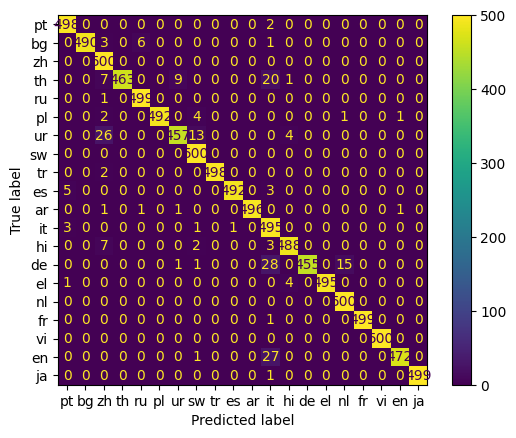

In [ ]:
ConfusionMatrixDisplay.from_predictions(ds['test']['labels'],preds,display_labels = list(label2id.keys()))

### Default Pooling provided better and faster results for this model, but average of the embeddings may have converged to the same accuracy if training was continued.